# EDA

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Read Cleaned Data

From the data cleaning notebook, there are two different files:
1. `annual_aqi_clean.csv` is annual summary data from the EPA's AirData system
2. `aqs_by_county_clean.csv` is sensor data that was collected via the EPA's AQS API

The annual summary data will contain more information on the number of days in various areas such as days with AQI measureed, good, moderate, unhealthy, very unhealthy, and hazardous air quality.  There are also columns concerning specific pollutant measurements like pm2.5, pm10, and ozone.

The AQS data is also annual summary data, but on a measured pollutant basis.  So it contains values for measurements of specific pollutants in counties for the year.

In [2]:
# Annual AQI summary data
aqi = pd.read_csv('data/annual_aqi_clean.csv')

# AQS sensor data collected via API
aqs = pd.read_csv('data/aqs_by_county_clean.csv')

In [3]:
aqi.head()

,state,county,year,days_with_aqi,good_days,mod_days,uh_sens_days,uh_days,v_uh_days,haz_days,...,days_pm2.5,days_pm10,births_low,avg_weight_low,avg_ges_age_low,births_all,avg_weight_all,avg_ges_age_all,pct_low,high_rate
0,california,alameda,2009,365,190,162,12,1,0,0,...,234,0,1136.0,1980.992,34.260,17700.0,3314.900,38.817,0.064,0
1,california,butte,2009,365,185,148,31,1,0,0,...,101,0,90.0,1963.467,33.809,1907.0,3390.433,38.850,0.047,0
2,california,contra costa,2009,365,274,84,6,1,0,0,...,78,0,669.0,2002.323,34.283,10976.0,3330.618,38.823,0.061,0
3,california,el dorado,2009,362,240,82,33,7,0,0,...,2,1,88.0,1981.477,34.511,1410.0,3330.952,38.821,0.062,0
4,california,fresno,2009,365,109,140,80,36,0,0,...,129,0,1068.0,1959.166,33.788,14117.0,3271.289,38.489,0.076,0


In [4]:
aqi.shape

(4635, 26)

In [5]:
aqi.columns

Index(['state', 'county', 'year', 'days_with_aqi', 'good_days', 'mod_days',
       'uh_sens_days', 'uh_days', 'v_uh_days', 'haz_days', 'max_aqi',
       '90_per_aqi', 'median_aqi', 'days_co', 'days_no2', 'days_ozone',
       'days_pm2.5', 'days_pm10', 'births_low', 'avg_weight_low',
       'avg_ges_age_low', 'births_all', 'avg_weight_all', 'avg_ges_age_all',
       'pct_low', 'high_rate'],
      dtype='object')

In [6]:
aqi.dtypes

state               object
county              object
year                 int64
days_with_aqi        int64
good_days            int64
mod_days             int64
uh_sens_days         int64
uh_days              int64
v_uh_days            int64
haz_days             int64
max_aqi              int64
90_per_aqi           int64
median_aqi           int64
days_co              int64
days_no2             int64
days_ozone           int64
days_pm2.5           int64
days_pm10            int64
births_low         float64
avg_weight_low     float64
avg_ges_age_low    float64
births_all         float64
avg_weight_all     float64
avg_ges_age_all    float64
pct_low            float64
high_rate            int64
dtype: object

In [7]:
aqi['year'].sort_values().unique()

array([2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2020])

### Filter Data

The EPA generally uses 75% as a number of observations to ensure relevancy.  So we'll filter the aqi data to only look at records where `days_with_aqi` is greater than 75% of the days in a year.

In [8]:
aqi = aqi[aqi['days_with_aqi'] > (365 * .75)]

In [9]:
aqi[[col for col in aqi.columns if col.find('_days') != -1]].describe()

,good_days,mod_days,uh_sens_days,uh_days,v_uh_days,haz_days
count,4053.000000,4053.000000,4053.000000,4053.000000,4053.000000,4053.000000
mean,258.318776,91.740933,8.193190,1.767580,0.182087,0.052800
std,65.911144,54.021439,16.113551,6.721601,1.625441,0.597523
min,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,225.000000,50.000000,0.000000,0.000000,0.000000,0.000000
50%,272.000000,82.000000,2.000000,0.000000,0.000000,0.000000
75%,307.000000,125.000000,8.000000,1.000000,0.000000,0.000000
max,365.000000,339.000000,122.000000,74.000000,74.000000,18.000000


When looking through these descriptive statistics for all of the day counts for the general air quality, most of the days are concentrated in good and moderate.  Unhealthy, very unhealthy, and hazardous are largely abset--even the 75th percentile values for all of those categories is 0, so very few locations had many days with that type of air quality.

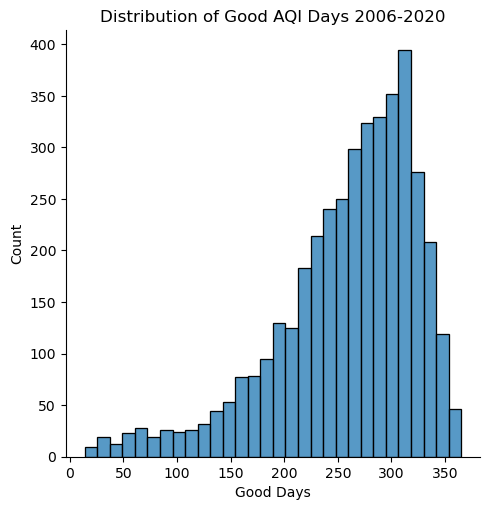

In [10]:
sns.displot(data=aqi,
            x='good_days',
            kind='hist',
            bins=30).set(xlabel='Good Days',
                         title='Distribution of Good AQI Days 2006-2020');

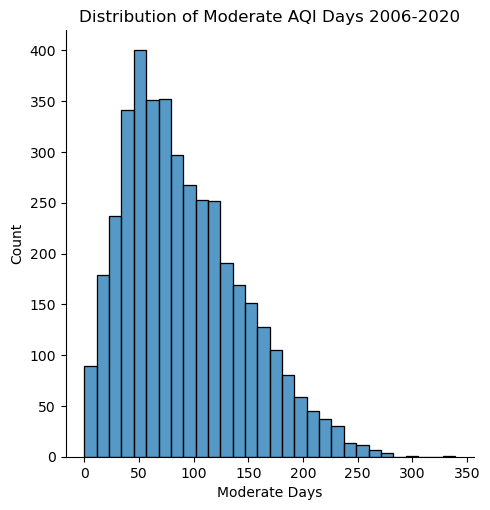

In [11]:
sns.displot(data=aqi,
            x='mod_days',
            kind='hist',
            bins=30).set(xlabel='Moderate Days',
                         title='Distribution of Moderate AQI Days 2006-2020');

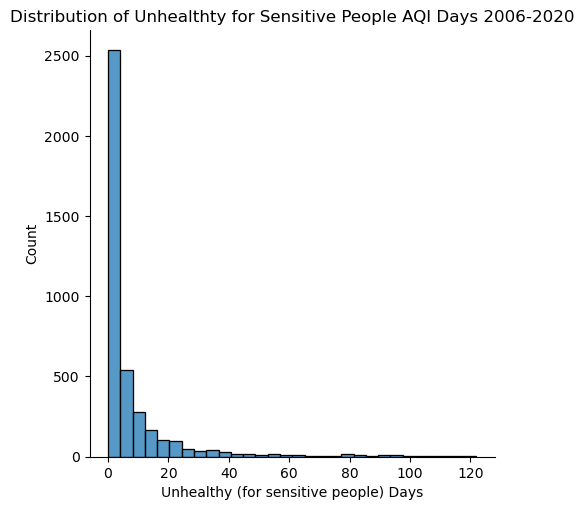

In [12]:
sns.displot(data=aqi,
            x='uh_sens_days',
            kind='hist',
            bins=30).set(xlabel='Unhealthy (for sensitive people) Days',
                         title='Distribution of Unhealthty for Sensitive People AQI Days 2006-2020');

Overall, looking at these distributions gives an idea that the data is has mostly good and moderate day counts, and most categories beyond that have very few records.

Let's look at the counts for the pollutant count days:

In [13]:
aqi[[col for col in aqi.columns if col.find('days_') != -1]].describe()

,days_with_aqi,days_co,days_no2,days_ozone,days_pm2.5,days_pm10
count,4053.000000,4053.000000,4053.000000,4053.000000,4053.000000,4053.000000
mean,360.255366,0.899087,9.765606,195.551443,146.970392,7.068838
std,13.702277,7.450258,25.284352,97.780622,97.245154,26.588710
min,275.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,362.000000,0.000000,0.000000,140.000000,71.000000,0.000000
50%,365.000000,0.000000,0.000000,199.000000,146.000000,0.000000
75%,365.000000,0.000000,6.000000,254.000000,207.000000,1.000000
max,366.000000,131.000000,300.000000,366.000000,366.000000,346.000000


Check to see top 10 observations for each pollutant (count of days where pollutant was the main pollutant)

In [14]:
aqi.sort_values(by='days_pm10', ascending=False).head(10)

,state,county,year,days_with_aqi,good_days,mod_days,uh_sens_days,uh_days,v_uh_days,haz_days,...,days_pm2.5,days_pm10,births_low,avg_weight_low,avg_ges_age_low,births_all,avg_weight_all,avg_ges_age_all,pct_low,high_rate
1562,arizona,mohave,2014,365,356,9,0,0,0,0,...,19,346,84.0,2010.381,33.810,1408.0,3296.321,38.606,0.060,0
1150,arizona,mohave,2019,365,358,7,0,0,0,0,...,28,337,86.0,2026.930,34.605,1300.0,3286.232,38.587,0.066,0
189,arizona,mohave,2020,358,349,8,1,0,0,0,...,25,333,73.0,1979.753,34.219,1410.0,3312.628,38.701,0.052,0
738,arizona,mohave,2018,363,350,12,1,0,0,0,...,33,330,67.0,1869.194,33.209,1306.0,3319.267,38.640,0.051,0
2346,arizona,mohave,2017,355,349,6,0,0,0,0,...,32,323,61.0,2059.115,34.869,1351.0,3342.070,38.754,0.045,0
2757,arizona,mohave,2016,357,336,21,0,0,0,0,...,34,323,73.0,2022.151,34.083,1311.0,3301.013,38.628,0.056,0
1942,arizona,mohave,2015,364,354,10,0,0,0,0,...,41,323,75.0,2118.587,35.315,1382.0,3304.677,38.721,0.054,0
1660,idaho,canyon,2014,365,351,13,0,1,0,0,...,46,319,116.0,2056.474,34.664,2452.0,3372.118,38.762,0.047,0
3605,arizona,mohave,2013,358,343,14,1,0,0,0,...,42,316,81.0,1934.222,33.136,1420.0,3330.672,38.590,0.057,0
3198,colorado,mesa,2006,365,309,54,1,1,0,0,...,86,274,94.0,2117.979,34.882,1555.0,3280.681,38.699,0.060,0


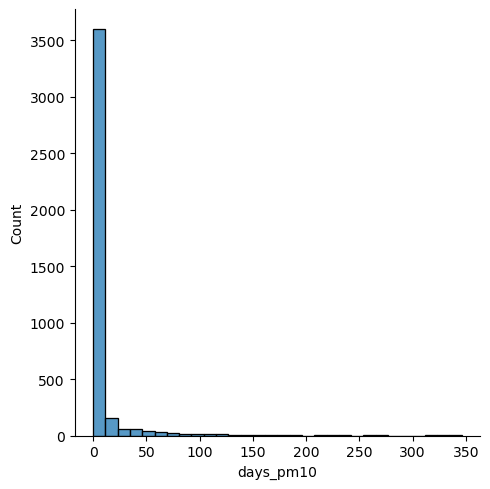

In [15]:
sns.displot(aqi,
            x='days_pm10',
            kind='hist',
            bins=30);

In [16]:
aqi.sort_values(by='days_pm2.5', ascending=False).head(10)

,state,county,year,days_with_aqi,good_days,mod_days,uh_sens_days,uh_days,v_uh_days,haz_days,...,days_pm2.5,days_pm10,births_low,avg_weight_low,avg_ges_age_low,births_all,avg_weight_all,avg_ges_age_all,pct_low,high_rate
320,iowa,black hawk,2020,366,311,55,0,0,0,0,...,366,0,92.0,1952.815,33.500,1177.0,3313.748,38.506,0.078,0
508,oregon,linn,2020,366,283,72,0,1,3,7,...,366,0,47.0,2028.170,34.085,992.0,3433.526,38.929,0.047,0
2855,hawaii,hawaii,2016,366,22,339,5,0,0,0,...,366,0,142.0,2018.317,34.387,1747.0,3240.639,38.613,0.081,0
3535,oregon,linn,2012,366,319,47,0,0,0,0,...,366,0,48.0,1973.000,34.085,1004.0,3419.492,38.888,0.048,0
3395,iowa,johnson,2012,366,204,162,0,0,0,0,...,366,0,83.0,1939.217,33.566,1468.0,3356.779,38.890,0.057,0
3545,texas,ector,2012,366,307,59,0,0,0,0,...,366,0,201.0,1965.502,33.910,2650.0,3205.254,38.146,0.076,0
288,hawaii,hawaii,2020,366,357,9,0,0,0,0,...,366,0,113.0,1970.274,33.885,1474.0,3253.391,38.575,0.077,0
3076,oregon,linn,2016,366,333,33,0,0,0,0,...,366,0,33.0,2068.242,34.424,1027.0,3460.391,39.009,0.032,0
3136,washington,snohomish,2016,366,317,46,3,0,0,0,...,366,0,346.0,2005.176,34.228,7413.0,3398.136,38.926,0.047,0
711,texas,ector,2008,366,303,62,1,0,0,0,...,366,0,232.0,2060.901,34.379,2524.0,3138.964,37.774,0.092,1


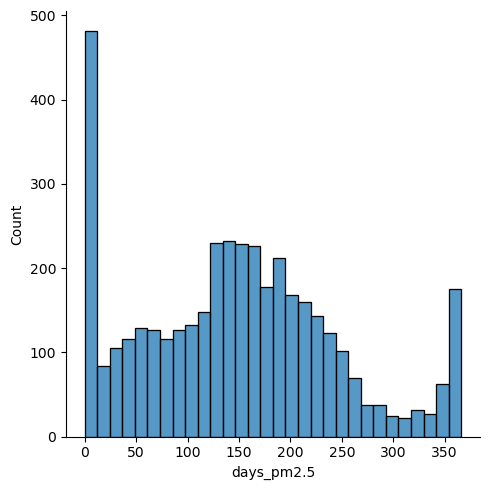

In [17]:
sns.displot(aqi,
            x='days_pm2.5',
            kind='hist',
            bins=30);

In [18]:
aqi.sort_values(by='days_ozone', ascending=False).head(10)

,state,county,year,days_with_aqi,good_days,mod_days,uh_sens_days,uh_days,v_uh_days,haz_days,...,days_pm2.5,days_pm10,births_low,avg_weight_low,avg_ges_age_low,births_all,avg_weight_all,avg_ges_age_all,pct_low,high_rate
256,florida,manatee,2020,366,355,11,0,0,0,0,...,0,0,197.0,1962.452,33.848,2925.0,3280.180,38.573,0.067,0
3325,colorado,jefferson,2012,366,201,113,48,4,0,0,...,0,0,373.0,2068.874,35.134,4910.0,3240.132,38.931,0.076,0
237,colorado,jefferson,2020,366,231,108,23,4,0,0,...,0,0,338.0,2054.979,34.692,4458.0,3228.077,38.736,0.076,0
3348,florida,pasco,2012,366,325,41,0,0,0,0,...,0,0,221.0,1998.837,33.914,3575.0,3330.736,38.597,0.062,0
3344,florida,okaloosa,2012,366,334,32,0,0,0,0,...,0,0,116.0,2021.871,34.483,2029.0,3321.100,38.636,0.057,0
3340,florida,manatee,2012,366,337,28,1,0,0,0,...,0,0,156.0,1928.372,33.603,2691.0,3338.885,38.691,0.058,0
2805,colorado,jefferson,2016,366,245,101,17,3,0,0,...,0,0,325.0,2075.511,35.256,4795.0,3256.981,38.998,0.068,0
2821,florida,manatee,2016,366,343,23,0,0,0,0,...,0,0,182.0,1980.780,34.005,2828.0,3300.979,38.639,0.064,0
2827,florida,osceola,2016,366,342,24,0,0,0,0,...,0,0,264.0,2042.117,34.367,3662.0,3255.339,38.554,0.072,0
2829,florida,pasco,2016,366,328,37,1,0,0,0,...,0,0,247.0,1938.061,33.482,3820.0,3306.050,38.585,0.065,0


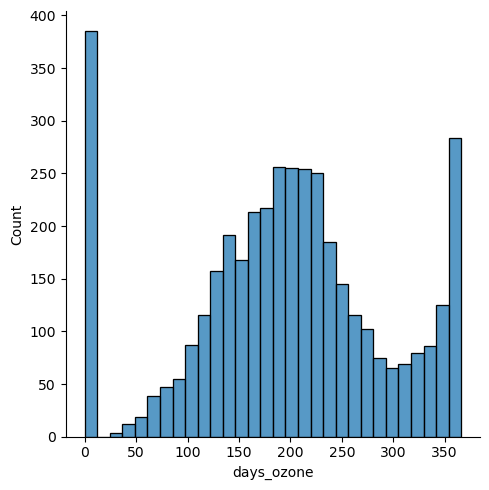

In [19]:
sns.displot(aqi,
            x='days_ozone',
            kind='hist',
            bins=30);

In [20]:
aqi.sort_values(by='days_co', ascending=False).head(10)

,state,county,year,days_with_aqi,good_days,mod_days,uh_sens_days,uh_days,v_uh_days,haz_days,...,days_pm2.5,days_pm10,births_low,avg_weight_low,avg_ges_age_low,births_all,avg_weight_all,avg_ges_age_all,pct_low,high_rate
654,montana,yellowstone,2008,366,348,18,0,0,0,0,...,235,0,93.0,2070.118,34.430,1641.0,3336.265,38.652,0.057,0
699,ohio,stark,2008,352,239,93,20,0,0,0,...,60,0,193.0,2002.347,34.487,3066.0,3328.280,38.637,0.063,0
3234,new york,niagara,2006,361,285,67,9,0,0,0,...,84,0,79.0,1941.177,33.342,1516.0,3380.598,38.679,0.052,0
4082,ohio,stark,2007,355,189,123,36,7,0,0,...,60,0,218.0,1870.353,33.220,3207.0,3309.664,38.459,0.068,0
1905,virginia,richmond city,2014,365,364,1,0,0,0,0,...,0,0,221.0,1880.665,33.674,2296.0,3201.070,38.470,0.096,1
3262,ohio,montgomery,2006,365,269,89,7,0,0,0,...,101,0,337.0,1942.030,33.467,5035.0,3299.333,38.473,0.067,0
689,ohio,franklin,2008,366,234,113,18,1,0,0,...,76,3,930.0,1931.647,33.851,13397.0,3294.628,38.691,0.069,0
4080,ohio,montgomery,2007,365,239,110,15,1,0,0,...,96,0,337.0,1970.905,34.009,5008.0,3303.120,38.501,0.067,0
3889,ohio,summit,2013,365,308,55,2,0,0,0,...,102,0,304.0,1925.961,33.523,4430.0,3312.173,38.670,0.069,0
4083,ohio,summit,2007,365,221,107,29,8,0,0,...,81,0,264.0,1949.451,33.405,4426.0,3327.888,38.486,0.060,0


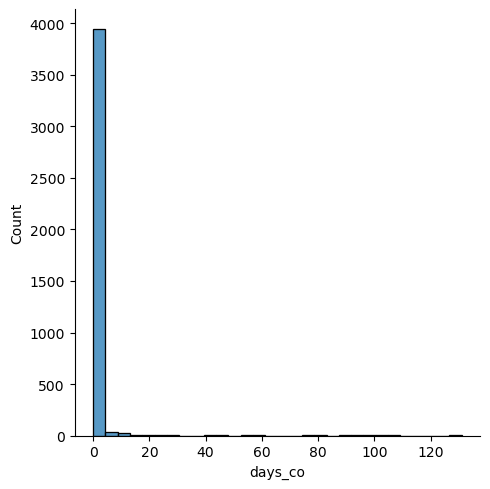

In [21]:
sns.displot(aqi,
            x='days_co',
            kind='hist',
            bins=30);

In [22]:
aqi.sort_values(by='days_no2', ascending=False).head(10)

,state,county,year,days_with_aqi,good_days,mod_days,uh_sens_days,uh_days,v_uh_days,haz_days,...,days_pm2.5,days_pm10,births_low,avg_weight_low,avg_ges_age_low,births_all,avg_weight_all,avg_ges_age_all,pct_low,high_rate
2299,virginia,alexandria city,2015,345,337,8,0,0,0,0,...,0,24,131.0,2014.603,34.443,2481.0,3330.991,38.894,0.053,0
565,virginia,norfolk city,2020,365,362,3,0,0,0,0,...,87,1,215.0,1980.651,34.363,2425.0,3231.675,38.439,0.089,1
1905,virginia,richmond city,2014,365,364,1,0,0,0,0,...,0,0,221.0,1880.665,33.674,2296.0,3201.070,38.470,0.096,1
3233,new york,nassau,2006,348,299,48,1,0,0,0,...,86,0,771.0,1995.351,34.265,10992.0,3303.814,38.556,0.070,0
3128,virginia,norfolk city,2016,362,357,5,0,0,0,0,...,99,2,261.0,1985.720,34.107,2767.0,3223.951,38.451,0.094,1
1109,virginia,norfolk city,2018,365,357,8,0,0,0,0,...,98,0,273.0,1942.253,33.941,2649.0,3208.348,38.359,0.103,1
1903,virginia,norfolk city,2014,365,343,22,0,0,0,0,...,106,1,254.0,1987.941,34.382,2926.0,3224.776,38.585,0.087,1
3941,virginia,norfolk city,2013,365,353,12,0,0,0,0,...,104,0,219.0,1961.219,34.266,2527.0,3265.973,38.623,0.087,1
2715,virginia,norfolk city,2017,363,357,6,0,0,0,0,...,104,0,241.0,1914.332,33.938,2702.0,3228.238,38.407,0.089,1
3563,virginia,alexandria city,2012,366,298,53,11,4,0,0,...,2,1,128.0,1960.805,33.938,2061.0,3327.698,38.858,0.062,0


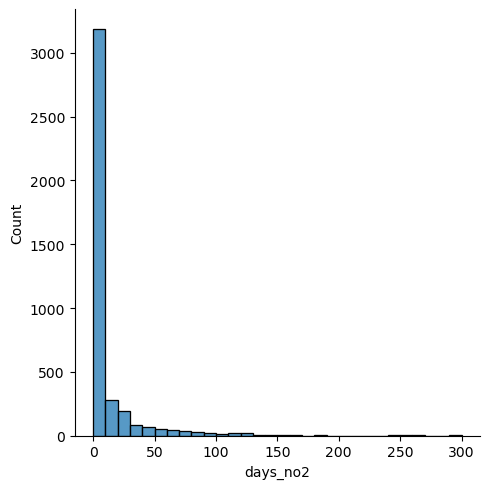

In [23]:
sns.displot(aqi,
            x='days_no2',
            kind='hist',
            bins=30);

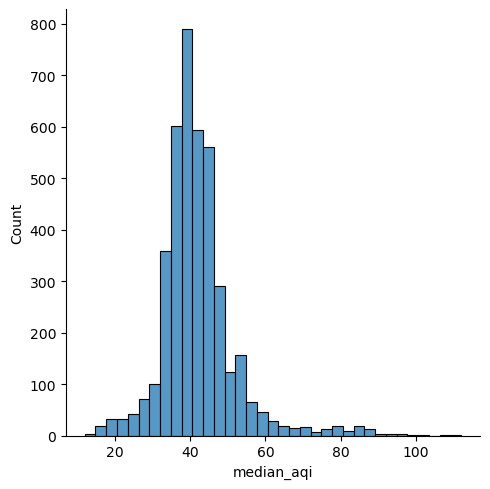

In [24]:
sns.displot(aqi,
            x='median_aqi',
            kind='hist',
            bins=35);

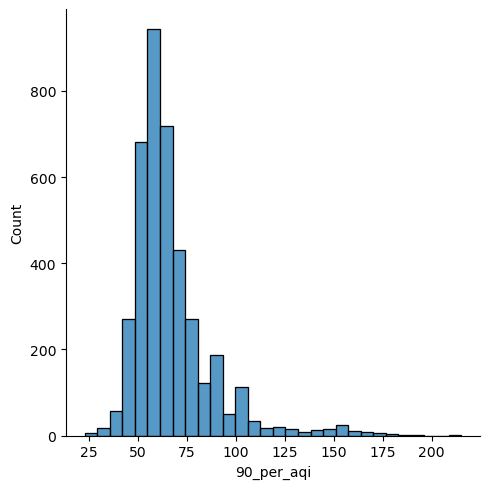

In [25]:
sns.displot(aqi,
            x='90_per_aqi',
            kind='hist',
            bins=30);

Let's look a bit at the target data

Observations with low birthweight percentage (highest 10)

In [26]:
aqi.sort_values(by='pct_low', ascending=False).head(10)

,state,county,year,days_with_aqi,good_days,mod_days,uh_sens_days,uh_days,v_uh_days,haz_days,...,days_pm2.5,days_pm10,births_low,avg_weight_low,avg_ges_age_low,births_all,avg_weight_all,avg_ges_age_all,pct_low,high_rate
4496,louisiana,caddo,2010,363,261,91,11,0,0,0,...,60,0,402.0,1977.264,33.945,2986.0,3088.602,37.874,0.135,1
1768,mississippi,hinds,2014,365,180,184,0,1,0,0,...,274,0,363.0,1931.003,33.959,2779.0,3065.051,37.917,0.131,1
4233,louisiana,caddo,2011,365,240,107,18,0,0,0,...,68,0,372.0,1939.624,33.747,2871.0,3099.827,37.870,0.130,1
401,mississippi,hinds,2020,366,249,116,1,0,0,0,...,265,0,290.0,2035.279,34.610,2226.0,3081.211,37.933,0.130,1
287,georgia,richmond,2020,366,268,97,1,0,0,0,...,267,15,262.0,1965.233,34.351,2099.0,3124.365,38.307,0.125,1
2559,mississippi,hinds,2017,365,256,109,0,0,0,0,...,243,0,322.0,1909.012,33.643,2572.0,3069.387,37.916,0.125,1
3445,mississippi,hinds,2012,366,241,122,2,1,0,0,...,249,0,327.0,1986.190,34.217,2668.0,3082.299,37.973,0.123,1
1360,mississippi,hinds,2019,365,256,109,0,0,0,0,...,222,0,290.0,2038.310,34.379,2351.0,3094.378,37.923,0.123,1
2153,mississippi,hinds,2015,365,217,148,0,0,0,0,...,253,0,307.0,1967.857,34.094,2566.0,3085.500,37.993,0.120,1
3938,virginia,hampton city,2013,359,313,44,2,0,0,0,...,181,0,48.0,1738.479,32.729,399.0,3205.329,38.266,0.120,1


Observations with low birthweight percentage (lowest 10)

In [27]:
aqi.sort_values(by='pct_low', ascending=True).head(10)

,state,county,year,days_with_aqi,good_days,mod_days,uh_sens_days,uh_days,v_uh_days,haz_days,...,days_pm2.5,days_pm10,births_low,avg_weight_low,avg_ges_age_low,births_all,avg_weight_all,avg_ges_age_all,pct_low,high_rate
460,new york,tompkins,2020,364,359,5,0,0,0,0,...,0,0,13.0,2204.077,35.077,530.0,3403.653,39.079,0.025,0
1419,new york,tompkins,2019,356,349,7,0,0,0,0,...,0,0,14.0,2174.000,35.571,510.0,3414.189,39.043,0.027,0
1907,washington,cowlitz,2014,323,309,14,0,0,0,0,...,323,0,24.0,1982.417,34.125,804.0,3443.707,39.232,0.030,0
1467,oregon,linn,2019,365,280,83,2,0,0,0,...,365,0,33.0,2000.636,33.939,1048.0,3498.659,39.032,0.031,0
593,california,humboldt,2008,364,349,15,0,0,0,0,...,50,4,37.0,1884.730,33.556,1168.0,3430.532,38.935,0.032,0
3076,oregon,linn,2016,366,333,33,0,0,0,0,...,366,0,33.0,2068.242,34.424,1027.0,3460.391,39.009,0.032,0
3084,pennsylvania,blair,2016,366,285,79,2,0,0,0,...,166,4,28.0,1989.750,34.143,846.0,3410.701,38.995,0.033,0
2735,wisconsin,la crosse,2017,360,311,49,0,0,0,0,...,166,0,27.0,2059.185,33.889,819.0,3462.660,39.269,0.033,0
2649,ohio,medina,2017,364,292,72,0,0,0,0,...,157,0,41.0,2051.732,34.878,1231.0,3438.399,38.957,0.033,0
1478,pennsylvania,centre,2019,365,267,98,0,0,0,0,...,162,0,27.0,2042.370,34.296,819.0,3428.707,39.076,0.033,0


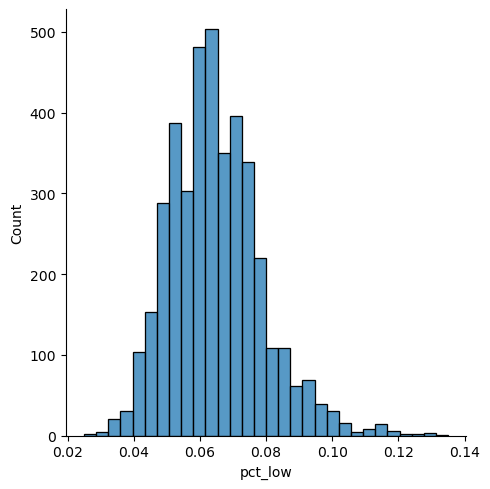

In [28]:
sns.displot(aqi,
            x='pct_low',
            kind='hist',
            bins=30)

In [29]:
aqi['high_rate'].value_counts(normalize=True)

0    0.902048
1    0.097952
Name: high_rate, dtype: float64

/var/folders/jw/x8qx8p4s749cv2jcz2hv8q180000gn/T/ipykernel_39309/944428341.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(aqi.corr());


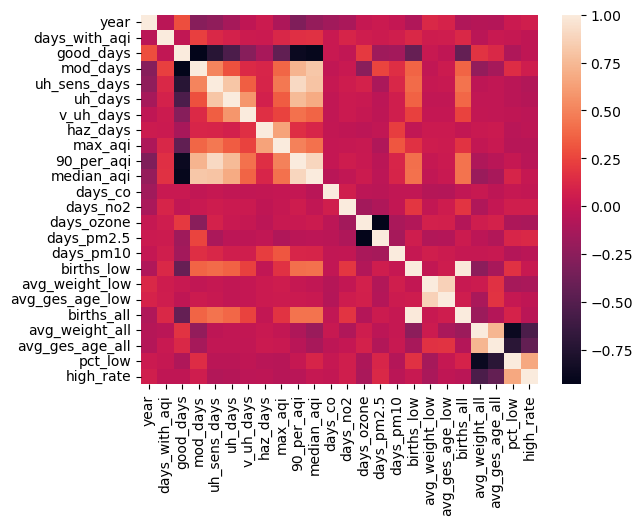

In [30]:
sns.heatmap(aqi.corr());

median aqi
days no2
days pm2.5
mod days

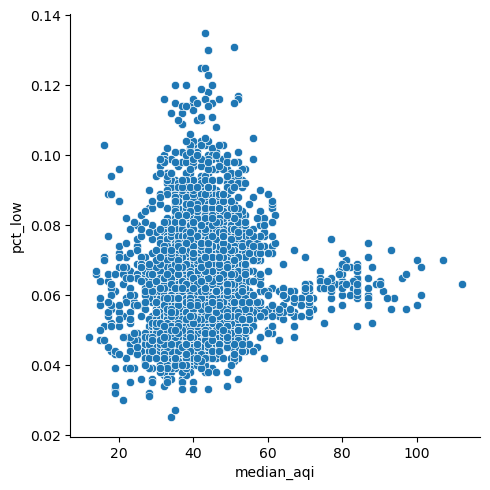

In [31]:
sns.relplot(aqi, x='median_aqi', y='pct_low')

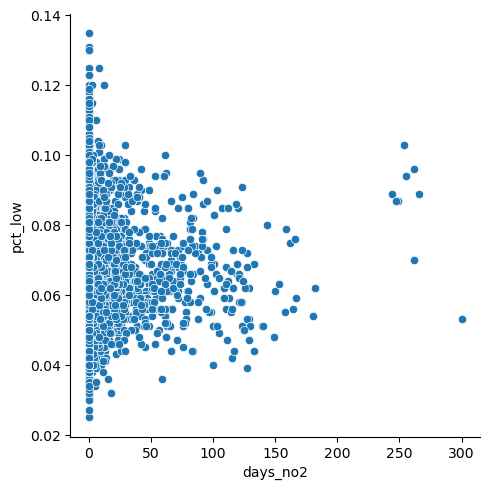

In [32]:
sns.relplot(aqi, x='days_no2', y='pct_low')

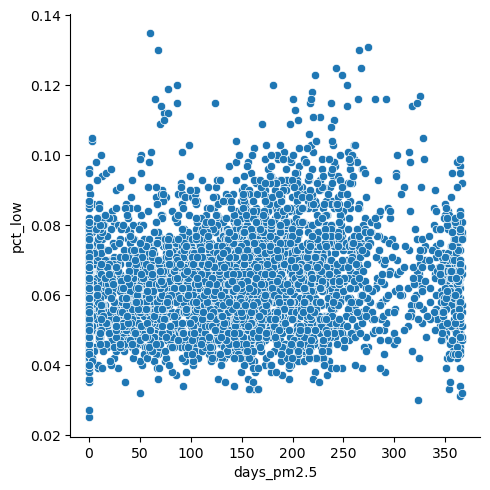

In [33]:
sns.relplot(aqi, x='days_pm2.5', y='pct_low')

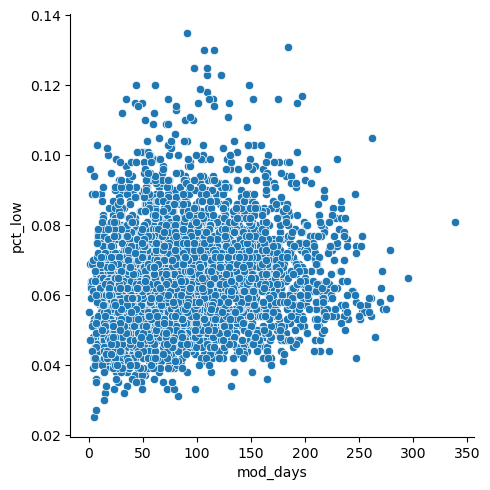

In [34]:
sns.relplot(aqi, x='mod_days', y='pct_low')

In [35]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.regularizers import l2

from tensorflow.keras.activations import elu

In [36]:
aqi.columns

Index(['state', 'county', 'year', 'days_with_aqi', 'good_days', 'mod_days',
       'uh_sens_days', 'uh_days', 'v_uh_days', 'haz_days', 'max_aqi',
       '90_per_aqi', 'median_aqi', 'days_co', 'days_no2', 'days_ozone',
       'days_pm2.5', 'days_pm10', 'births_low', 'avg_weight_low',
       'avg_ges_age_low', 'births_all', 'avg_weight_all', 'avg_ges_age_all',
       'pct_low', 'high_rate'],
      dtype='object')

In [37]:
X = aqi[['days_with_aqi', 'good_days', 'mod_days',
       'uh_sens_days', 'uh_days', 'v_uh_days', 'haz_days', 'max_aqi',
       '90_per_aqi', 'median_aqi', 'days_co', 'days_no2', 'days_ozone',
       'days_pm2.5', 'days_pm10']]

y = aqi['high_rate']

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=.2,
                                                    stratify=y,
                                                    random_state=5)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3242, 15), (811, 15), (3242,), (811,))

In [39]:
train_baseline = pd.DataFrame(y_train).value_counts(normalize=True).iloc[0]
test_baseline = pd.DataFrame(y_test).value_counts(normalize=True).iloc[0]
train_baseline, test_baseline

(0.9019123997532388, 0.9025893958076449)

In [40]:
ss = StandardScaler()
X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.transform(X_test)

In [41]:
custom_elu = lambda x: elu(x, alpha=1e-3)

In [42]:
model = Sequential()
model.add(Dense(16, input_dim=X_train_ss.shape[1], activation=custom_elu,
               kernel_regularizer=l2(0.001)))
# model.add(Dense(300, activation='relu'))
# model.add(Dense(100, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(60, activation=custom_elu))
model.add(Dropout(0.1))
model.add(Dense(120, activation=custom_elu))
model.add(Dropout(0.1))
model.add(Dense(60, activation=custom_elu))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', 
              loss='bce', 
              metrics=['accuracy'])

history = model.fit(X_train_ss, y_train,
                    batch_size=32, epochs=50,
                    validation_data=(X_test_ss, y_test))

Epoch 1/50


2023-01-19 11:09:28.818568: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


102/102 [==============================] - 1s 2ms/step - loss: 0.3597 - accuracy: 0.9001 - val_loss: 0.3272 - val_accuracy: 0.9026
Epoch 2/50
102/102 [==============================] - 0s 1ms/step - loss: 0.3180 - accuracy: 0.9019 - val_loss: 0.3183 - val_accuracy: 0.9026
Epoch 3/50
102/102 [==============================] - 0s 1ms/step - loss: 0.3157 - accuracy: 0.9019 - val_loss: 0.3134 - val_accuracy: 0.9026
Epoch 4/50
102/102 [==============================] - 0s 1ms/step - loss: 0.3111 - accuracy: 0.9019 - val_loss: 0.3091 - val_accuracy: 0.9026
Epoch 5/50
102/102 [==============================] - 0s 1ms/step - loss: 0.3073 - accuracy: 0.9019 - val_loss: 0.3086 - val_accuracy: 0.9026
Epoch 6/50
102/102 [==============================] - 0s 1ms/step - loss: 0.3015 - accuracy: 0.9019 - val_loss: 0.3132 - val_accuracy: 0.9026
Epoch 7/50
102/102 [==============================] - 0s 1ms/step - loss: 0.2982 - accuracy: 0.9022 - val_loss: 0.3067 - val_accuracy: 0.9026
Epoch 8/50
102/10

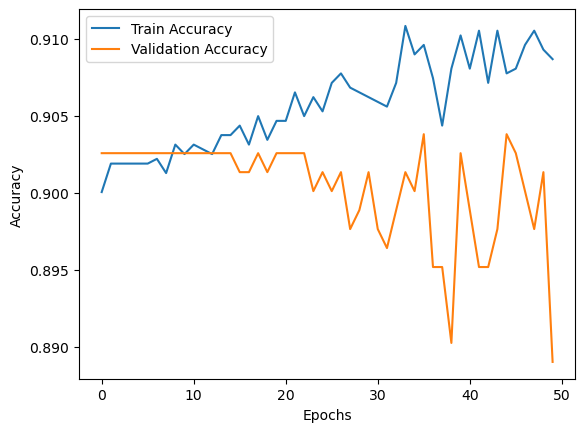

In [43]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend();

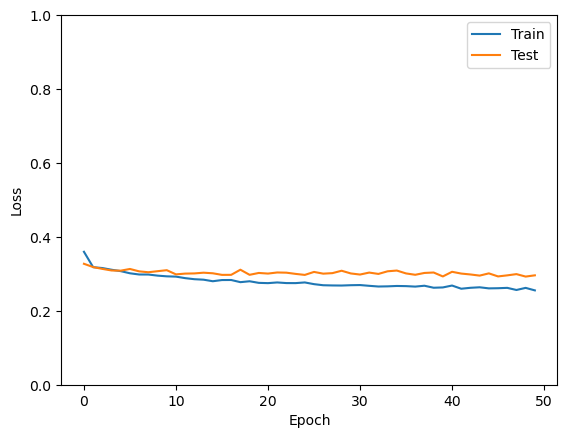

In [44]:
# plt.figure(figsize=(8,8))
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0,1])
plt.legend();

### Random Forest Classifier

In [45]:
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import (cross_val_score, GridSearchCV, 
                                     train_test_split)
from sklearn.pipeline import Pipeline

#### AQI Data

In [54]:
rand_forest = RandomForestClassifier()

In [55]:
rand_forest.fit(X_train, y_train)

RandomForestClassifier()

In [56]:
cross_val_score(rand_forest, X_train, y_train).mean()

0.9056140501055754

In [64]:
# score with defaults
rand_forest.score(X_train, y_train), rand_forest.score(X_test, y_test)

(1.0, 0.8976572133168927)

In [80]:
# configure pipeline
rf_pipe = Pipeline([
    ('rf', RandomForestClassifier())
])

# min_samples_leaf
# criterion

rf_params = {
    'rf__n_estimators': [100, 125, 150],
    'rf__max_depth': [5, 15, 25],
    'rf__min_samples_leaf': [3, 5, 6, 7],
    'rf__bootstrap': [False],
    'rf__warm_start': [True, False],
    'rf__max_features': ['sqrt', 3, 6, 8, 9]
}


# attempt 6 
# rf_params = {
#     'rf__n_estimators': [100, 125, 150],
#     'rf__max_depth': [5, 15, 25],
#     'rf__min_samples_leaf': [3, 5, 6, 7],
#     'rf__bootstrap': [False],
#     'rf__warm_start': [True, False],
#     'rf__max_features': ['sqrt', 3, 6, 8, 9]
# }

# attempt 5 - first parameters with leaf instead of split
# rf_params = {
#     'rf__n_estimators': [10, 50, 100],
#     'rf__max_depth': [5, 10, 15],
#     'rf__min_samples_leaf': [2, 3, 4, 5],
#     'rf__bootstrap': [True, False],
#     'rf__warm_start': [True, False],
#     'rf__max_features': ['sqrt', 3, 4, 5, 6]
# }

# attempt 4
# rf_params = {
#     'rf__n_estimators': [100, 125, 150, 200],
#     'rf__max_depth': [10, 15, 20, 25, 100],
#     'rf__min_samples_leaf': [4, 5, 6, 7],
#     'rf__bootstrap': [False],
#     'rf__warm_start': [True, False],
#     'rf__max_features': ['sqrt', 4, 5, 6, 7]
# }

# attempt 3
# rf_params = {
#     'rf__n_estimators': [100, 125, 150, 200],
#     'rf__max_depth': [10, 15, 20, 25],
#     'rf__min_samples_split': [4, 5, 6, 7],
#     'rf__bootstrap': [False],
#     'rf__warm_start': [True, False],
#     'rf__max_features': ['sqrt', 4, 5, 6, 7]
# }

# attempt 2
# rf_params = {
#     'rf__n_estimators': [50, 100, 150],
#     'rf__max_depth': [10, 20, 50],
#     'rf__min_samples_split': [5, 10, 25],
#     'rf__bootstrap': [True, False],
#     'rf__warm_start': [True, False],
#     'rf__max_features': ['sqrt', 5, 10, 25]
# }

# attempt 1
# rf_params = {
#     'rf__n_estimators': [10, 50, 100],
#     'rf__max_depth': [5, 10, 15],
#     'rf__min_samples_split': [2, 3, 4, 5],
#     'rf__bootstrap': [True, False],
#     'rf__warm_start': [True, False],
#     'rf__max_features': ['sqrt', 3, 4, 5, 6]
# }

In [81]:
gs = GridSearchCV(rf_pipe, rf_params, n_jobs=-1, verbose=1)
gs.fit(X_train, y_train)
gs.best_params_

# attempt 6 (0.9580505860579889, 0.8988902589395807)
# {'rf__bootstrap': False,
#  'rf__max_depth': 15,
#  'rf__max_features': 'sqrt',
#  'rf__min_samples_leaf': 3,
#  'rf__n_estimators': 125,
#  'rf__warm_start': False}

# attempt 5 (0.9558914250462678, 0.9001233045622689)
# {'rf__bootstrap': False,
#  'rf__max_depth': 15,
#  'rf__max_features': 'sqrt',
#  'rf__min_samples_leaf': 3,
#  'rf__n_estimators': 100,
#  'rf__warm_start': False}

# attempt 4 (0.9487970388648982, 0.8976572133168927)
# {'rf__bootstrap': False,
#  'rf__max_depth': 15,
#  'rf__max_features': 6,
#  'rf__min_samples_leaf': 5,
#  'rf__n_estimators': 100,
#  'rf__warm_start': False}

# attempt 3 (0.9932140653917335, 0.9001233045622689)
# {'rf__bootstrap': False,
#  'rf__max_depth': 15,
#  'rf__max_features': 4,
#  'rf__min_samples_split': 5,
#  'rf__n_estimators': 100,
#  'rf__warm_start': False}

# attempt 2 (1.0, 0.8976572133168927)
# {'rf__bootstrap': False,
#  'rf__max_depth': 20,
#  'rf__max_features': 'sqrt',
#  'rf__min_samples_split': 5,
#  'rf__n_estimators': 150,
#  'rf__warm_start': True}

# attempt 1 (0.9401603948180136, 0.903822441430333)
# {'rf__bootstrap': False,
#  'rf__max_depth': 10,
#  'rf__max_features': 6,
#  'rf__min_samples_split': 5,
#  'rf__n_estimators': 100,
#  'rf__warm_start': False}

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


{'rf__bootstrap': False,
 'rf__max_depth': 15,
 'rf__max_features': 'sqrt',
 'rf__min_samples_leaf': 3,
 'rf__n_estimators': 125,
 'rf__warm_start': False}

In [82]:
# score with best params
gs.score(X_train, y_train), gs.score(X_test, y_test)

(0.9580505860579889, 0.8988902589395807)

In [65]:
aqi['high_rate'].value_counts(normalize=Tr)

0    0.902048
1    0.097952
Name: high_rate, dtype: float64

#### AQS Data

In [99]:
aqs_rf = RandomForestClassifier()

In [100]:
aqs_rf.fit(X_train_aqs, y_train_aqs)

RandomForestClassifier()

In [101]:
cross_val_score(aqs_rf, X_train_aqs, y_train_aqs).mean()

0.8714362395521815

In [104]:
# score with defaults
aqs_rf.score(X_train_aqs, y_train_aqs), aqs_rf.score(X_test_aqs, y_test_aqs)

(1.0, 0.8866995073891626)

In [116]:
# configure pipeline
aqs_rf_pipe = Pipeline([
    ('rf', RandomForestClassifier())
])

# min_samples_leaf
# criterion

aqs_rf_params = {
    'rf__n_estimators': np.arange(25, 300, 50),
    'rf__criterion' : ["gini", "entropy", "log_loss"],
    'rf__max_depth': np.arange(5, 100, 10),
    'rf__min_samples_leaf': np.arange(3, 11),
    'rf__bootstrap': [False, True],
    'rf__warm_start': [True, False],
    'rf__max_features': np.arange(1, 6)
}


# attempt 3
# aqs_rf_params = {
#     'rf__n_estimators': [25, 100, 150, 200],
#     'rf__max_depth': [3, 5, 25, 50],
#     'rf__min_samples_leaf': [3, 5, 6, 7, 20],
#     'rf__bootstrap': [False, True],
#     'rf__warm_start': [True, False],
#     'rf__max_features': ['sqrt', None, 3, 6, 8, 15]
# }

# attempt 2
# aqs_rf_params = {
#     'rf__n_estimators': [100, 125, 150],
#     'rf__max_depth': [5, 15, 25],
#     'rf__min_samples_leaf': [3, 5, 6, 7],
#     'rf__bootstrap': [False, True],
#     'rf__warm_start': [True, False],
#     'rf__max_features': ['sqrt', 3, 6, 8, 9]
# }


# attempt 1
# aqs_rf_params = {
#     'rf__n_estimators': [10, 50, 100],
#     'rf__max_depth': [5, 10, 15],
#     'rf__min_samples_split': [2, 3, 4, 5],
#     'rf__bootstrap': [True, False],
#     'rf__warm_start': [True, False],
#     'rf__max_features': ['sqrt', 3, 4, 5, 6]
# }

In [ ]:
aqs_gs = GridSearchCV(aqs_rf_pipe, aqs_rf_params, n_jobs=-1, verbose=1)
aqs_gs.fit(X_train_aqs, y_train_aqs)
aqs_gs.best_params_


# attempt 3 (0.9542645241038319, 0.8719211822660099)
# {'rf__bootstrap': True,
#  'rf__max_depth': 50,
#  'rf__max_features': None,
#  'rf__min_samples_leaf': 3,
#  'rf__n_estimators': 25,
#  'rf__warm_start': False}


# attempt 2 (0.8800988875154512, 0.8768472906403941)
# {'rf__bootstrap': False,
#  'rf__max_depth': 5,
#  'rf__max_features': 3,
#  'rf__min_samples_leaf': 3,
#  'rf__n_estimators': 125,
#  'rf__warm_start': False}

# attempt 1 (0.8825710754017305, 0.8768472906403941)
# {'rf__bootstrap': True,
#  'rf__max_depth': 5,
#  'rf__max_features': 'sqrt',
#  'rf__min_samples_split': 4,
#  'rf__n_estimators': 10,
#  'rf__warm_start': True}

Fitting 5 folds for each of 28800 candidates, totalling 144000 fits


In [113]:
# score with best_params
aqs_gs.score(X_train_aqs, y_train_aqs), aqs_gs.score(X_test_aqs, y_test_aqs)

(0.9542645241038319, 0.8719211822660099)

### Logistic Regression Classifer

#### Annual AQI Data

In [83]:
from sklearn.linear_model import LogisticRegression

In [87]:
lr = LogisticRegression(max_iter=10_000)

In [98]:
y_train.value_counts(normalize=True), y_test.value_counts(normalize=True)

(0    0.901912
 1    0.098088
 Name: high_rate, dtype: float64,
 0    0.902589
 1    0.097411
 Name: high_rate, dtype: float64)

In [88]:
lr.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

In [89]:
lr.score(X_train, y_train), lr.score(X_test, y_test)

(0.9009870450339297, 0.9025893958076449)

#### AQS Data

In [90]:
aqs.columns

Index(['state', 'county', 'year', 'Carbon monoxide', 'Nitrogen dioxide (NO2)',
       'Ozone', 'PM10 Total 0-10um STP', 'PM2.5 - Local Conditions',
       'births_low', 'avg_weight_low', 'avg_ges_age_low', 'births_all',
       'avg_weight_all', 'avg_ges_age_all', 'pct_low', 'high_rate'],
      dtype='object')

In [91]:
X_aqs = aqs[['Carbon monoxide', 'Nitrogen dioxide (NO2)',
       'Ozone', 'PM10 Total 0-10um STP', 'PM2.5 - Local Conditions']]

y_aqs = aqs['high_rate']

In [92]:
X_train_aqs, X_test_aqs, y_train_aqs, y_test_aqs = train_test_split(X_aqs,\
                                                                   y_aqs,
                                                                   random_state=5,
                                                                    test_size=.2,                                                                
                                                                   stratify=y_aqs)

In [93]:
X_train_aqs.shape, X_test_aqs.shape, y_train_aqs.shape, y_test_aqs.shape

((809, 5), (203, 5), (809,), (203,))

In [97]:
y_train_aqs.value_counts(normalize=True), y_test_aqs.value_counts(normalize=True)

(0    0.878863
 1    0.121137
 Name: high_rate, dtype: float64,
 0    0.876847
 1    0.123153
 Name: high_rate, dtype: float64)

In [94]:
lr.fit(X_train_aqs, y_train_aqs)

LogisticRegression(max_iter=10000)

In [96]:
lr.score(X_train_aqs, y_train_aqs), lr.score(X_test_aqs, y_test_aqs)

(0.8788627935723115, 0.8768472906403941)

Regression

In [46]:
# X = aqi[['days_with_aqi', 'good_days', 'mod_days',
#        'uh_sens_days', 'uh_days', 'v_uh_days', 'haz_days', 'max_aqi',
#        '90_per_aqi', 'median_aqi', 'days_co', 'days_no2', 'days_ozone',
#        'days_pm2.5', 'days_pm10']]

# y = aqi['pct_low']

In [47]:
# X_train, X_test, y_train, y_test = train_test_split(X,y,
#                                                     test_size=.2,
#                                                     random_state=5)
# X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [48]:
# ss = StandardScaler()
# X_train_ss = ss.fit_transform(X_train)
# X_test_ss = ss.transform(X_test)

In [49]:
# model = Sequential()
# model.add(Dense(15, input_dim=X_train_ss.shape[1], activation='relu',
#                kernel_regularizer=l2(0.001)))
# # model.add(Dense(300, activation='relu'))
# # model.add(Dense(100, activation='relu'))
# model.add(Dropout(0.1))
# model.add(Dense(60, activation='relu'))
# model.add(Dropout(0.1))
# model.add(Dense(120, activation='relu'))
# model.add(Dropout(0.1))
# model.add(Dense(60, activation='relu'))
# model.add(Dense(1, activation=None))

# model.compile(optimizer='adam', 
#               loss='mse', 
#               metrics=RootMeanSquaredError())

# history = model.fit(X_train_ss, y_train,
#                     batch_size=32, epochs=100,
#                     validation_data=(X_test_ss, y_test),
#                     validation_split=0.25)

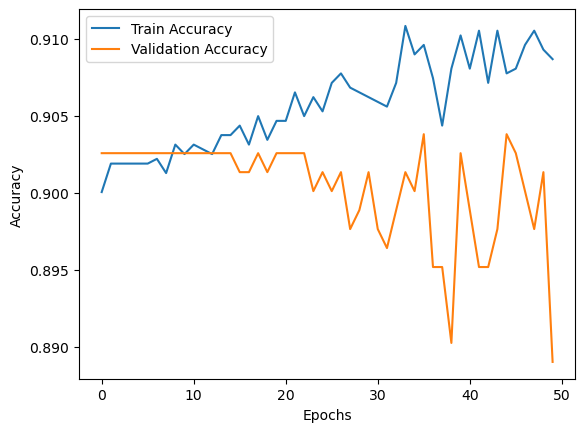

In [50]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend();

In [51]:
# # plt.figure(figsize=(8,8))
# plt.plot(history.history['loss'], label='Train')
# plt.plot(history.history['val_loss'], label='Test')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.ylim([0,1])
# plt.legend();

In [52]:
# y_pred = model.predict(X_test_ss)

In [53]:
# plt.scatter(y_test, y_pred, alpha=.6)